# Khai báo thư viện và nạp dữ liệu

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset 


import numpy as np
import pandas as pd

import re

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.tokenize import word_tokenize # hỗ trợ về văn bản

import matplotlib.pyplot as plt

In [2]:
train_path = "train.csv"
test_path = "test.csv"

In [3]:
# Lựa chọn thiết bị sử dụng huấn luyện
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device # phải set thiết bị

device(type='cpu')

In [4]:
train_df = pd.read_csv(train_path)

In [5]:
test_df = pd.read_csv(test_path)

In [6]:
# Dữ liệu train có bao nhiêu bản ghi?
# Dữ liệu test có bao nhiêu bản ghi khác rỗng?
# Dữ liệu có những nhãn gì?

# Viết chương trình vào đây
print(train_df.shape)
print(test_df.shape)
print(train_df.isnull().sum())
print(test_df.isnull().sum())

print(train_df.Category.unique())


(5970, 3)
(9968, 2)
Id          0
Category    0
Tweet       0
dtype: int64
Id          5968
Category    5968
dtype: int64
['negative' 'neutral' 'positive' 'Tweet']


# Tiền xử lý dữ liệu

## Loại dữ liệu giá trị rỗng

In [7]:
train_df.head()

,Id,Category,Tweet
0,635769805279248384,negative,Not Available
1,635930169241374720,neutral,IOS 9 App Transport Security. Mm need to check...
2,635950258682523648,neutral,"Mar if you have an iOS device, you should down..."
3,636030803433009153,negative,@jimmie_vanagon my phone does not run on lates...
4,636100906224848896,positive,Not sure how to start your publication on iOS?...


In [8]:
from sqlalchemy.sql.elements import Null
from sqlalchemy.sql.expression import null
from os import replace
# Thực hiện với tập train
# thực hiện loại bỏ cột id
# thực hiện loại bỏ những dòng rỗng
# thực hiện loại bỏ những dòng có Tweet là "Not Available"

# code ở đây
train_df = train_df.drop('Id', axis=1)
train_df.dropna(axis=0,inplace=True)
train_df.Tweet.replace('Not Available',None, inplace=True)
train_df.Category.replace('Tweet',None, inplace=True)
train_df.dropna(axis=0,inplace=True)
train_df

,Category,Tweet
1,neutral,IOS 9 App Transport Security. Mm need to check...
2,neutral,"Mar if you have an iOS device, you should down..."
3,negative,@jimmie_vanagon my phone does not run on lates...
4,positive,Not sure how to start your publication on iOS?...
5,neutral,"Two Dollar Tuesday is here with Forklift 2, Qu..."
...,...,...
5963,positive,"Ok ed let's do this, Zlatan, greizmann and Lap..."
5964,neutral,Goal level: Zlatan 90k by Friday? = Posting e...
5965,neutral,@YouAreMyArsenal Wouldn't surprise me if we en...
5966,neutral,Rib injury for Zlatan against Russia is a big ...


In [9]:
test_df.head()

,Id,Category
0,6.289494e+17,dear @Microsoft the newOoffice for Mac is grea...
1,6.289766e+17,@Microsoft how about you make a system that do...
2,6.290232e+17,Not Available
3,6.291792e+17,Not Available
4,6.291863e+17,If I make a game as a #windows10 Universal App...


In [10]:
# Thực hiện với tập test
# Sửa tên cột Category thành Tweet
# thực hiện loại bỏ cột id
# thực hiện loại bỏ những dòng rỗng
# thực hiện loại bỏ những dòng có Tweet là "Not Available"

# code ở đây
test_df = test_df.rename(columns = {'Category':'Tweet'})
test_df.drop('Id', axis=1,inplace=True)
test_df.dropna(axis=0,inplace=True)
test_df.Tweet.replace('Not Available',None, inplace=True)
test_df.dropna(axis=0,inplace=True)
test_df

,Tweet
0,dear @Microsoft the newOoffice for Mac is grea...
1,@Microsoft how about you make a system that do...
4,If I make a game as a #windows10 Universal App...
5,"Microsoft, I may not prefer your gaming branch..."
6,@MikeWolf1980 @Microsoft I will be downgrading...
...,...
3994,Anybody with a Steak &amp; Shake or IHOP move ...
3995,I am assembling an epic Pancake Posse for an I...
3996,do you work at Ihop tomorrow @carlysunshine_
3997,23 Aug 00;30 #771NAS Rescue193 returned from T...


In [11]:
# Sau khi thực hiện loại bỏ dữ liệu thì 
# tập train gồm bao nhiêu dòng
print (len(train_df))
# tập test gồm bao nhiêu dòng
print (len(test_df))


5421
3640


## Xử lý mất cân băng dữ liệu

In [12]:
# Trong tập train có bao nhiêu phân lớp mỗi phân lớp có bao nhiêu dòng dữ liệu

# code ở đây
print(train_df.Category.unique())
print(train_df.Category.value_counts())


['neutral' 'negative' 'positive']
positive    2599
neutral     1953
negative     869
Name: Category, dtype: int64


In [13]:
# dữ liệu có bị mất cân bằng không?
#có bị mất cân bằng

## Undersampling

In [14]:
# n là số dòng của phân lớp có ít dữ liệu nhất
# code ở đây
n = train_df.Category.value_counts().min()
n

869

In [15]:
# thực hiện tách phân lớp 
# neg_df là dữ liệu của phân lớp negative
# pos_df là dữ liệu của phân lớp positive
# neut_df là dữ liệu của phân lớp neutral

# code ở đây
neg_df = train_df[train_df['Category']=='negative']
pos_df = train_df[train_df['Category']=='positive']
neut_df = train_df[train_df['Category']=='neutral']


In [16]:
# Undersampling các phân lớp có nhiều dữ liệu hơn
# code ở đây
pos_undersampled  = pos_df.iloc[:n]
neut_undersampled = neut_df.iloc[:n]

In [17]:
# hợp nhất 3 phân lớp lại neg_df, pos_undersampled, neut_undersampled
# code ở đây
balanced_train_df = pd.concat([neg_df, pos_undersampled,neut_undersampled], ignore_index=True)
balanced_train_df

,Category,Tweet
0,negative,@jimmie_vanagon my phone does not run on lates...
1,negative,@_tomcc @bartwerf please stop walking and work...
2,negative,"@DeltaAssist yes, I asked an attendant to prin..."
3,negative,ok inbox on iOS has a pretty animation for the...
4,negative,Lost my iPad for the 2nd time today
...,...,...
2602,neutral,"Honestly, lack of 3rd party support should hav..."
2603,neutral,@ZeroSHEARER @ZhugeEX again an improvement. I ...
2604,neutral,@THEREALRTU but then I suppose the 3rd party p...
2605,neutral,@16KTS @Flareonys Nintendo needs some more 3rd...


In [18]:
# kiểm tra số lượng dữ liệu của từng phân lớp
# code ở đây
balanced_train_df.Category.value_counts()

negative    869
positive    869
neutral     869
Name: Category, dtype: int64

In [19]:
# chia train test 
# code ở đây
train_clean_df, test_clean_df = train_test_split(balanced_train_df, test_size=0.15)

In [20]:
train_clean_df

,Category,Tweet
873,positive,"Met with iOS Developer today. We may have a ""g..."
1007,positive,"Get the popcorn (or coffee in my case) ready, ..."
2232,neutral,F-Sport Friday with CT200h F-Sport. This Lexus...
770,negative,"Elections seem the most probable scenario, as ..."
1577,positive,A FB friend of mine just posted that seeing Ma...
...,...,...
869,positive,Not sure how to start your publication on iOS?...
814,negative,I think I posted surprise incest in the Golden...
1784,neutral,"Checks 2.0 will not be submitted tomorrow, but..."
1743,neutral,YouTube Gaming Launches Tomorrow with iOS and ...


In [21]:
test_clean_df

,Category,Tweet
758,negative,"After all these Tsipras headlines, I wonder if..."
210,negative,Please stop acting how if you were a Mariah Ca...
90,negative,Refusing to own a gun may cost Jeb Bush dearly...
659,negative,Wow Tiger Woods is SHANKING his way through th...
642,negative,crying bc it's monday and there's no teen wolf
...,...,...
1575,positive,Magic Mike XXL is better than the 1st. I learn...
1012,positive,"If you're an iPhone user like myself, new phon..."
2211,neutral,Also keep in mind that due to Labor Day we did...
2391,neutral,Van Halen and LL Cool J talk about Michael Jac...


In [22]:
train_set = list(train_clean_df.to_records(index=False))
test_set = list(test_clean_df.to_records(index=False))

In [23]:
train_set[:10]

[('positive', 'Met with iOS Developer today. We may have a "go". 8-)'),
 ('positive', 'Get the popcorn (or coffee in my case) ready, folks. 1 hour till the new iPhone event! Tuning in from #Asheville, NC. http://t.co/sTI3xeHGhV'),
 ('neutral', 'F-Sport Friday with CT200h F-Sport. This Lexus eats asphalt, sips fuel. http://t.co/wNGT4ByHoj'),
 ('negative', 'Elections seem the most probable scenario, as Tsipras made a strategic mistake... https://t.co/9wGXuyTyu2 #Greece'),
 ('positive', 'A FB friend of mine just posted that seeing Magic Mike XXL was the best night of her life. If only she knew what my typical sat night is.'),
 ('positive', '@theguyliner Mariah Carey - Fantasy The distance between it and the 2nd most played is pretty vast.'),
 ('positive', "It's Friday and the end of a short week...Result!! Lets celebrate with @jtimberlake and Madonna after 8am this morning! Dave &amp; Heidi x"),
 ('positive', 'I was 8 turning 9 in the 4th grade when I started to support Justin. Now Im a f

In [24]:
def remove_links_mentions(tweet):
    # Loại bỏ link ví dụ:  "http://t.co/iquQxxqxRI" hoặc "https://t.co/gZkIfIs0xu"
    # loại bỏ tên người đề cập ví dụ ""@pecunium" hoặc "@guardian"
    # code ở đây
    link_re_pattern = r'https?:\/\/t.co\/\w*'
    mention_re_pattern = r'@\w*'
    tweet = re.sub(link_re_pattern, "", tweet)
    tweet = re.sub(mention_re_pattern, "", tweet)
    return tweet.lower()

In [25]:
s = '...and Jeb Bush is third in the polls and losing donors. Be fair and balance...@karlrove @FoxNews. https://t.co/Ka2km3bua6'
remove_links_mentions(s)

'...and jeb bush is third in the polls and losing donors. be fair and balance... . '

In [26]:
remove_links_mentions('...and Jeb Bush is third in the polls and losing donors. Be fair and balance...@karlrove @FoxNews. https://t.co/Ka2km3bua6')

'...and jeb bush is third in the polls and losing donors. be fair and balance... . '

## Tokenize

Sử dụng word_tokenize của nltk để token hóa dữ các đoạn tweet sau khi đã được làm sạch

In [27]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [28]:
train_set = [(label, word_tokenize(remove_links_mentions(tweet))) for label, tweet in train_set]
train_set[:3]

[('positive',
  ['met',
   'with',
   'ios',
   'developer',
   'today',
   '.',
   'we',
   'may',
   'have',
   'a',
   '``',
   'go',
   "''",
   '.',
   '8-',
   ')']),
 ('positive',
  ['get',
   'the',
   'popcorn',
   '(',
   'or',
   'coffee',
   'in',
   'my',
   'case',
   ')',
   'ready',
   ',',
   'folks',
   '.',
   '1',
   'hour',
   'till',
   'the',
   'new',
   'iphone',
   'event',
   '!',
   'tuning',
   'in',
   'from',
   '#',
   'asheville',
   ',',
   'nc',
   '.']),
 ('neutral',
  ['f-sport',
   'friday',
   'with',
   'ct200h',
   'f-sport',
   '.',
   'this',
   'lexus',
   'eats',
   'asphalt',
   ',',
   'sips',
   'fuel',
   '.'])]

In [29]:
test_set = [(label, word_tokenize(remove_links_mentions(tweet))) for label, tweet in test_set]
test_set[:3]

[('negative',
  ['after',
   'all',
   'these',
   'tsipras',
   'headlines',
   ',',
   'i',
   'wonder',
   'if',
   'they',
   "'ll",
   'still',
   'let',
   'the',
   'athens',
   'stock',
   'exchange',
   'open',
   'tomorrow',
   '.',
   'will',
   'be',
   'a',
   'total',
   'bloodbath',
   '.']),
 ('negative',
  ['please',
   'stop',
   'acting',
   'how',
   'if',
   'you',
   'were',
   'a',
   'mariah',
   'carey',
   'update',
   'account',
   '.']),
 ('negative',
  ['refusing',
   'to',
   'own',
   'a',
   'gun',
   'may',
   'cost',
   'jeb',
   'bush',
   'dearly',
   ':',
   'crime',
   'is',
   'out',
   'of',
   'control',
   'in',
   'america',
   '.',
   'bush',
   'going',
   'unarmed',
   'will',
   'ma',
   '...'])]

In [30]:
# lập danh sách các từ trong vocab
index2word = ["<PAD>", "<SOS>", "<EOS>"]
for ds in [train_set, test_set]:
    for label, tweet in ds:
        for token in tweet:
            if token not in index2word:
                index2word.append(token)

In [31]:
index2word

['<PAD>',
 '<SOS>',
 '<EOS>',
 'met',
 'with',
 'ios',
 'developer',
 'today',
 '.',
 'we',
 'may',
 'have',
 'a',
 '``',
 'go',
 "''",
 '8-',
 ')',
 'get',
 'the',
 'popcorn',
 '(',
 'or',
 'coffee',
 'in',
 'my',
 'case',
 'ready',
 ',',
 'folks',
 '1',
 'hour',
 'till',
 'new',
 'iphone',
 'event',
 '!',
 'tuning',
 'from',
 '#',
 'asheville',
 'nc',
 'f-sport',
 'friday',
 'ct200h',
 'this',
 'lexus',
 'eats',
 'asphalt',
 'sips',
 'fuel',
 'elections',
 'seem',
 'most',
 'probable',
 'scenario',
 'as',
 'tsipras',
 'made',
 'strategic',
 'mistake',
 '...',
 'greece',
 'fb',
 'friend',
 'of',
 'mine',
 'just',
 'posted',
 'that',
 'seeing',
 'magic',
 'mike',
 'xxl',
 'was',
 'best',
 'night',
 'her',
 'life',
 'if',
 'only',
 'she',
 'knew',
 'what',
 'typical',
 'sat',
 'is',
 'mariah',
 'carey',
 '-',
 'fantasy',
 'distance',
 'between',
 'it',
 'and',
 '2nd',
 'played',
 'pretty',
 'vast',
 "'s",
 'end',
 'short',
 'week',
 'result',
 'lets',
 'celebrate',
 'madonna',
 'after',

In [32]:
word = index2word[10]
word

'may'

In [33]:
# tạo ra token cho từ
word2index = {token: idx for idx, token in enumerate(index2word)}

In [34]:
word2index[word]

10

In [35]:
def label_map(label):
    # Hàm thực hiện mã hóa nhãn (label) từ chữ thành số
    # negative sẽ mã hóa thành 0
    # neutral sẽ mã hóa thành 1
    # positive sẽ mã hóa thành 2
    
    # code ở đây
    if label == 'negative':
      return 0
    if label == 'neutral':
      return 1
    if label == 'positive':
      return 2

In [36]:
seq_length = 32

In [37]:
def encode_and_pad(tweet, length):
    # sẽ thêm mã hóa các đoạn tweet từ chữ thành số dựa vào word2index
    # hàm sẽ thêm <SOS> vào đầu tweet và thêm <EOS> vào cuối tweet 
    # nếu tweet quá dài thì cắt tweet rổi thêm <EOS>
    # sao cho tweet sau khi mã hóa có độ dài đúng bằng length
    
    # code ở đây
    x = [word2index['<SOS>']]+[word2index[t] for t in tweet]
    if len(x) < length:
      x = x + [word2index['<EOS>']]+[word2index['<PAD>']]*(length-(len(x)+1))
    elif len(x) >= length:
      x = x[:length-1] + [word2index['<EOS>']]
    return x


In [38]:
x = [word2index['<SOS>']]+[word2index[t] for t in tweet]
print(len(x))
print(len(x[:9]))

19
9


In [39]:
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in train_set]

In [40]:
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test_set]

In [41]:
for i in train_encoded[:3]:
    print(i)

([1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 8, 16, 17, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 2)
([1, 18, 19, 20, 21, 22, 23, 24, 25, 26, 17, 27, 28, 29, 8, 30, 31, 32, 19, 33, 34, 35, 36, 37, 24, 38, 39, 40, 28, 41, 8, 2], 2)
([1, 42, 43, 4, 44, 42, 8, 45, 46, 47, 48, 28, 49, 50, 8, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 1)


Load dữ liệu để sử dụng cho torch

In [42]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)


# Xây dựng mô hình LSTM sử dụng PyTorch

In [43]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        # Lớp embedding lấy kích thước từ vựng và kích thước embedding làm đầu vào
        # Kích thước phần nhúng do bạn quyết định, nhưng kích thước phổ biến là từ 50 đến 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        # Lớp LSTM lấy kích thước nhúng và kích thước vectơ ẩn.
        # Kích thước ẩn do bạn quyết định, nhưng các giá trị phổ biến là 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        # Chúng tôi sử dụng bỏ học trước lớp cuối cùng để cải thiện với chính quy hóa
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        # Lớp được kết nối đầy đủ chiếm phần mờ ẩn của LSTM và
        # xuất ra một vectơ 3x1 của điểm số lớp.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        # Đầu vào được chuyển thành nhúng bằng cách chuyển nó tới lớp nhúng
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        # Các đầu vào nhúng được đưa vào LSTM cùng với trạng thái ẩn trước đó
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [44]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, 32, 0.2)
model = model.to(device)

In [45]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [46]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

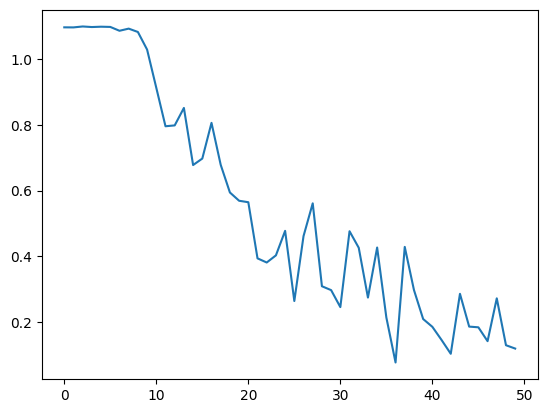

In [47]:
plt.plot(losses)

In [48]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5399999999999999

Thực hiện các thử nghiệm sau với class BiLSTM_SentimentAnalysis
- sử dụng bidirectional LSTM
- tăng số lượng layer của LSTM, thêm dropout cho các layer
- thử nghiệm tăng độ dài đầu vào
- thực hiện với các thử nghiệm trên với GRU


tài liệu tham khảo [torch.nn.LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html), [torch.nn.GRU](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)

# bidirectional LSTM

In [67]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        # Lớp embedding lấy kích thước từ vựng và kích thước embedding làm đầu vào
        # Kích thước phần nhúng do bạn quyết định, nhưng kích thước phổ biến là từ 50 đến 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        # Lớp LSTM lấy kích thước nhúng và kích thước vectơ ẩn.
        # Kích thước ẩn do bạn quyết định, nhưng các giá trị phổ biến là 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, bidirectional = True)

        # We use dropout before the final layer to improve with regularization
        # Chúng tôi sử dụng bỏ học trước lớp cuối cùng để cải thiện với chính quy hóa
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        # Lớp được kết nối đầy đủ chiếm phần mờ ẩn của LSTM và
        # xuất ra một vectơ 3x1 của điểm số lớp.
        self.fc = nn.Linear(hidden_dim*2, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        # Đầu vào được chuyển thành nhúng bằng cách chuyển nó tới lớp nhúng
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        # Các đầu vào nhúng được đưa vào LSTM cùng với trạng thái ẩn trước đó
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(2, batch_size, 32), torch.zeros(2, batch_size, 32))

In [50]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, seq_length, 0.2)
model = model.to(device)

In [51]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [52]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

In [53]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5114285714285715

# tăng số lượng layer của LSTM, thêm dropout cho các layer

In [68]:
model = BiLSTM_SentimentAnalysis(len(word2index), 128, seq_length, 0.4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [69]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

In [70]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5171428571428571

# tăng độ dài đầu vào


In [71]:
seq_length = 32
train_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in train_set]
test_encoded = [(encode_and_pad(tweet, seq_length), label_map(label)) for label, tweet in test_set]

In [72]:
batch_size = 50

train_x = np.array([tweet for tweet, label in train_encoded])
train_y = np.array([label for tweet, label in train_encoded])
test_x = np.array([tweet for tweet, label in test_encoded])
test_y = np.array([label for tweet, label in test_encoded])

train_ds = TensorDataset(torch.from_numpy(train_x), torch.from_numpy(train_y))
test_ds = TensorDataset(torch.from_numpy(test_x), torch.from_numpy(test_y))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)


In [73]:
model = BiLSTM_SentimentAnalysis(len(word2index), 128, seq_length, 0.4)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [74]:
epochs = 50
losses = []
for e in range(epochs):

    h0, c0 =  model.init_hidden()

    h0 = h0.to(device)
    c0 = c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, (h0, c0))
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

In [75]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, (h0, c0))
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5114285714285715

# GRU


In [59]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim, hidden_dim, dropout) :
        super().__init__()

        # The embedding layer takes the vocab size and the embeddings size as input
        # The embeddings size is up to you to decide, but common sizes are between 50 and 100.
        # Lớp embedding lấy kích thước từ vựng và kích thước embedding làm đầu vào
        # Kích thước phần nhúng do bạn quyết định, nhưng kích thước phổ biến là từ 50 đến 100.
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        # Lớp LSTM lấy kích thước nhúng và kích thước vectơ ẩn.
        # Kích thước ẩn do bạn quyết định, nhưng các giá trị phổ biến là 32, 64, 128
        self.lstm = nn.GRU(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        # Chúng tôi sử dụng bỏ học trước lớp cuối cùng để cải thiện với chính quy hóa
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        # Lớp được kết nối đầy đủ chiếm phần mờ ẩn của LSTM và
        # xuất ra một vectơ 3x1 của điểm số lớp.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, hidden):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        # Đầu vào được chuyển thành nhúng bằng cách chuyển nó tới lớp nhúng
        embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        # Các đầu vào nhúng được đưa vào LSTM cùng với trạng thái ẩn trước đó
        out, hidden = self.lstm(embs, hidden)

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, hidden
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32))

In [60]:
model = BiLSTM_SentimentAnalysis(len(word2index), 64, seq_length, 0.2)
model = model.to(device)

In [61]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [62]:
epochs = 50
losses = []
for e in range(epochs):

    h0 =  model.init_hidden()

    h0 = h0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, hidden = model(input, h0)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

In [64]:
batch_acc = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, hidden = model(input, h0)
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        batch_acc.append(accuracy_score(preds, target.tolist()))

sum(batch_acc)/len(batch_acc)

0.5371428571428571